# **Setting Up the Packages**

In [1]:
!pip install pandas matplotlib

# **Importing Library**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
import os

# **Dataset Upload**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 15_Digital_Bookstore_System.csv to 15_Digital_Bookstore_System.csv


# **Define Book Class**

In [4]:
class Book:
    def __init__(self, book_id, title, author, genre, price, stock, rating):
        self.book_id = str(book_id)
        self.title = title
        self.author = author
        self.genre = genre
        self.price = float(price)
        self.stock = int(stock)
        self.rating = float(rating)
        self.reviews = []

# **Define Shopping Cart Class**

In [5]:
class ShoppingCart:
    def __init__(self):
        self.items = {}

    def add_item(self, book, quantity):
        """Adding a book"""
        if quantity <= 0:
            raise ValueError("Quantity must be positive")
        if book.stock < quantity:
            raise ValueError(f"Insufficient stock. Only {book.stock} copies available.")

        if book.book_id in self.items:
            self.items[book.book_id] += quantity
        else:
            self.items[book.book_id] = quantity

    def remove_item(self, book_id):
        """Removing a book."""
        if book_id in self.items:
            del self.items[book_id]

    def calculate_total(self, bookstore):
        """Calculate total price with applicable discounts."""
        total = sum(bookstore.books[book_id].price * qty
                   for book_id, qty in self.items.items())
        if total > 50:
            total *= 0.9  # 10% discount
        return round(total, 2)

# **Define Disital Bookstore Class**

In [6]:
class DigitalBookstore:
    def __init__(self):
        self.books = {}
        self.sales_history = []
        self.users = {}
        self.load_books()

    #Database Management
    def load_books(self):
        df = pd.read_csv('15_Digital_Bookstore_System.csv')
        for _, row in df.iterrows():
            book_dict = row.to_dict()
            self.books[book_dict['Book ID']] = Book(
                book_id=book_dict['Book ID'],
                title=book_dict['Title'],
                author=book_dict['Author'],
                genre=book_dict['Genre'],
                price=book_dict['Price'],
                stock=book_dict['Stock'],
                rating=book_dict['Rating']
            )

    def save_books(self):
        books_data = []
        for book in self.books.values():
            books_data.append({
                'Book ID': book.book_id,
                'Title': book.title,
                'Author': book.author,
                'Genre': book.genre,
                'Price': book.price,
                'Stock': book.stock,
                'Rating': book.rating
            })
        df = pd.DataFrame(books_data)
        df.to_csv('15_Digital_Bookstore_System.csv', index=False)

    #Book Catalog Management
    def get_all_books(self):
        return list(self.books.values())

    def get_genres(self):
        return sorted(list(set(book.genre for book in self.books.values())))

    def search_books(self, criteria, value):
        results = []
        for book in self.books.values():
            if criteria == 'title' and value.lower() in book.title.lower():
                results.append(book)
            elif criteria == 'author' and value.lower() in book.author.lower():
                results.append(book)
            elif criteria == 'genre' and value.lower() == book.genre.lower():
                results.append(book)
            elif criteria == 'rating' and book.rating >= float(value):
                results.append(book)
        return results

    #Purchase Management
    def process_purchase(self, cart, user_id):
        """Process a purchase transaction."""
        total = cart.calculate_total(self)

        # Check stock availability
        for book_id, qty in cart.items.items():
            if self.books[book_id].stock < qty:
                raise ValueError(f"Insufficient stock for book: {self.books[book_id].title}")

        # Update stock and record sale
        sale_record = {
            'user_id': user_id,
            'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'items': {},
            'total': total
        }

        for book_id, qty in cart.items.items():
            book = self.books[book_id]
            book.stock -= qty
            sale_record['items'][book_id] = {
                'title': book.title,
                'quantity': qty,
                'price': book.price
            }

        self.sales_history.append(sale_record)
        self.save_books()
        return sale_record

    #Review System
    def add_review(self, book_id, user_id, rating, review_text):
        if book_id in self.books:
            book = self.books[book_id]
            review = {
                'user_id': user_id,
                'rating': rating,
                'text': review_text,
                'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            book.reviews.append(review)

            # Update book rating
            ratings = [review['rating'] for review in book.reviews]
            book.rating = round((sum(ratings) / len(ratings)), 1)
            self.save_books()

    #Book Analysi
    def get_top_rated_books(self, n=5):
        """Get top rated books."""
        return sorted(self.books.values(), key=lambda x: x.rating, reverse=True)[:n]

    def get_books_by_genre(self, genre):
        return [book for book in self.books.values() if book.genre.lower() == genre.lower()]

    #Sales Analysis
    def generate_sales_report(self, report_type, period=None):
        if report_type == 'most_purchased':
            book_sales = {}
            for sale in self.sales_history:
                for book_id, details in sale['items'].items():
                    book_sales[book_id] = book_sales.get(book_id, 0) + details['quantity']
            return sorted(book_sales.items(), key=lambda x: x[1], reverse=True)

        elif report_type == 'revenue':
            if period:
                filtered_sales = [sale for sale in self.sales_history
                                if sale['date'].startswith(period)]
                return sum(sale['total'] for sale in filtered_sales)
            return sum(sale['total'] for sale in self.sales_history)

        elif report_type == 'genre_trends':
            genre_sales = {}
            for sale in self.sales_history:
                for book_id, details in sale['items'].items():
                    genre = self.books[book_id].genre
                    genre_sales[genre] = genre_sales.get(genre, 0) + details['quantity']
            return genre_sales

    #Visualization
    def visualize_sales(self, visualization_type):
        plt.figure(figsize=(12, 6))

        if visualization_type == 'genre_popularity':
            genre_counts = {}
            for book in self.books.values():
                genre_counts[book.genre] = genre_counts.get(book.genre, 0) + 1

            plt.bar(genre_counts.keys(), genre_counts.values(), color='navy')
            plt.title('Books by Genre', pad=20, fontsize=14)
            plt.xlabel('Genre', fontsize=12)
            plt.ylabel('Number of Books', fontsize=12)
            plt.xticks(rotation=45, ha='right')

        elif visualization_type == 'price_distribution':
            prices = [book.price for book in self.books.values()]
            plt.hist(prices, bins=20, edgecolor='black', color='navy', alpha=0.7)
            plt.title('Book Price Distribution', pad=20, fontsize=14)
            plt.xlabel('Price ($)', fontsize=12)
            plt.ylabel('Number of Books', fontsize=12)

        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    #Recommendation System
    def recommend_books(self, user_id, method='similar_genre', book_id=None):
        if method == 'similar_genre' and book_id:
            if book_id not in self.books:
                return []
            target_genre = self.books[book_id].genre

            similar_books = [
                book for book in self.books.values()
                if book.genre == target_genre
                and book.book_id != book_id
                and book.rating >= 4.5
            ]
            return sorted(similar_books, key=lambda x: x.rating, reverse=True)[:5]

        return []


# **Testing and Demonstration**

In [7]:
def main():
    # Initialize bookstore
    print("🏪 Initializing Digital Bookstore System...")
    bookstore = DigitalBookstore()

    # Print available genres
    print("\n📚 Available Genres:")
    for genre in bookstore.get_genres():
        print(f"  • {genre}")

    # Print top rated books
    print("\n⭐ Top 5 Rated Books:")
    for book in bookstore.get_top_rated_books(5):
        print(f"  • {book.title} by {book.author} - Rating: {book.rating}")

    # Test search functionality
    print("\n🔍 Searching for 'King' books:")
    king_books = bookstore.search_books('author', 'King')
    for book in king_books:
        print(f"  • {book.title} by {book.author} - ${book.price}")

    # Test shopping cart
    cart = ShoppingCart()
    try:
        if king_books:
            cart.add_item(king_books[0], 1)
            print(f"\n🛒 Added to cart: {king_books[0].title}")

            # Process purchase
            receipt = bookstore.process_purchase(cart, "user123")
            print("\n✅ Purchase successful!")
            print("Receipt:", json.dumps(receipt, indent=2))
    except ValueError as e:
        print(f"❌ Error: {e}")

    # Visualize data
    print("\n📊 Generating Visualizations...")
    bookstore.visualize_sales('genre_popularity')
    bookstore.visualize_sales('price_distribution')


# **Execute Project**

🏪 Initializing Digital Bookstore System...

📚 Available Genres:
  • Biography
  • Children's Fiction
  • Classics
  • Fantasy
  • Fiction
  • Historical Fiction
  • Horror
  • Mystery
  • Non-Fiction
  • Romance
  • Science Fiction
  • Self-Help

⭐ Top 5 Rated Books:
  • Atomic Habits by James Clear - Rating: 4.9
  • To Kill a Mockingbird by Harper Lee - Rating: 4.9
  • Charlotte's Web by E.B. White - Rating: 4.9
  • Harry Potter and the Sorcerer's Stone by J.K. Rowling - Rating: 4.9
  • The Lord of the Rings by J.R.R. Tolkien - Rating: 4.9

🔍 Searching for 'King' books:
  • The Shining by Stephen King - $13.99
  • It by Stephen King - $14.5
  • Misery by Stephen King - $12.99
  • Pet Sematary by Stephen King - $11.5
  • The Stand by Stephen King - $18.99

🛒 Added to cart: The Shining

✅ Purchase successful!
Receipt: {
  "user_id": "user123",
  "date": "2025-01-28 16:24:03",
  "items": {
    "BK-1040": {
      "title": "The Shining",
      "quantity": 1,
      "price": 13.99
    }
  },

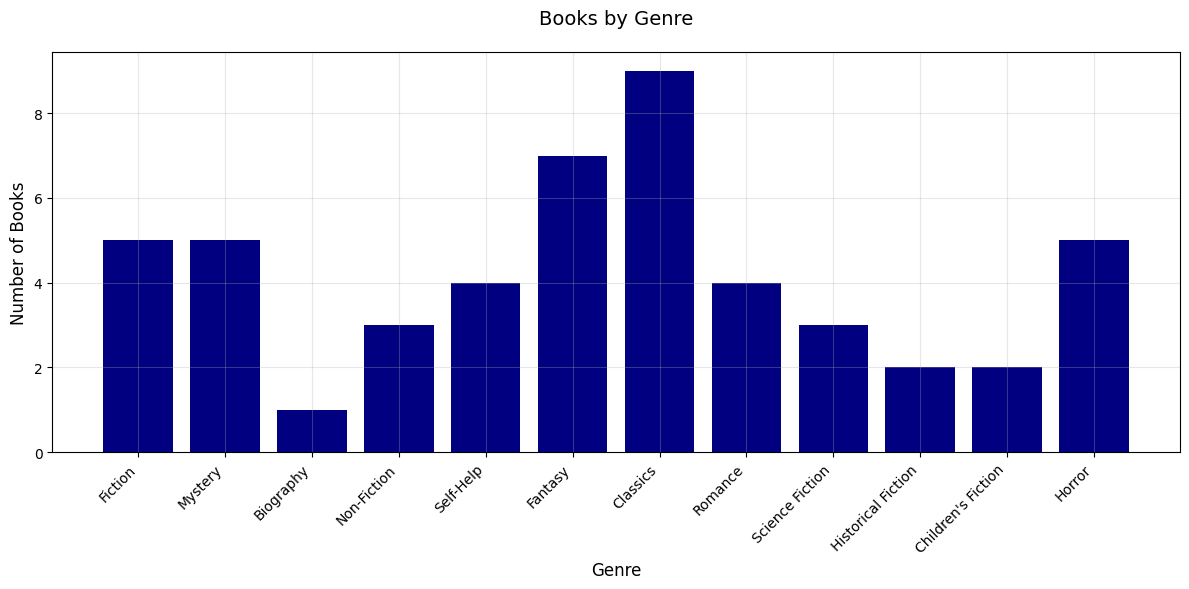

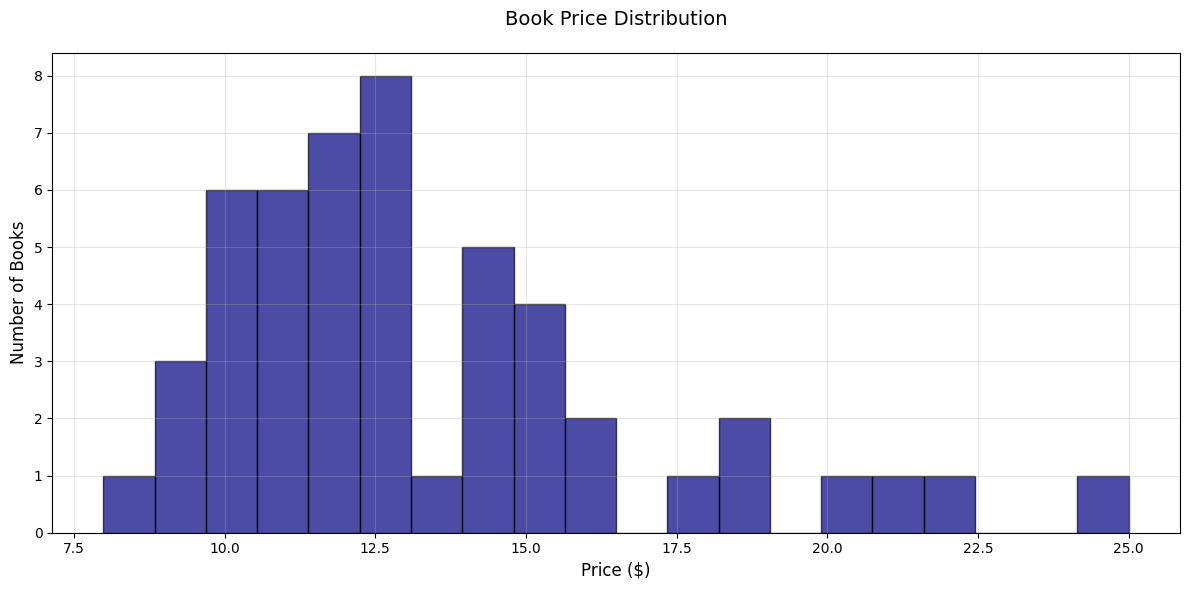

In [8]:
if __name__ == "__main__":
    main()